# Passive Sonar Classification
Este notebook tem por objetivo o treinamento de modelos de sonar passivo

In [1]:
import os
import warnings
from scipy import signal
from scipy.signal import decimate, convolve, spectrogram, lfilter, cheby2, butter, cheb2ord, hilbert
from librosa import stft, fft_frequencies, frames_to_time, feature
import numpy as np
import math
import pandas as pd
import soundfile as sf
import pandas as pd

import SonarFunctions

## Carga de Arquivos

In [11]:
ls data/raw/4Classes

Class1/  Class2/  Class3/  Class4/


In [2]:
import os
from os import walk

database = '4classes' # 4classes or shipsEar # este conjunto já está no formato padrão.
# uma pasta por classe.

file_folder = "./data/raw" # alterar para o ponto onde os dados crus estão armazenados

file_path = os.path.join(file_folder, database)

dict_classes = {} # dicionario com todos os nomes dos arquivos organizados 

f = []
for (dirpath, dirnames, filenames) in walk(top=file_path,topdown=True):
    if filenames == []: # lista de arquivos vazia
        continue
    filenames.sort()
    dict_classes[dirpath.split('/')[-1]] = {}
    for filename in filenames:
        #print(filename)
        # preciso pegar cada um dos arquivos e separar por classe
        dict_classes[dirpath.split('/')[-1]][filename.split('.')[0]] = os.path.join(dirpath,filename)

In [4]:
# célula onde o processamento é realizada
df_all_data = None

for iclass in dict_classes.keys():
    for irun in dict_classes[iclass].keys():
        df_run = pd.DataFrame()
        #print(dict_classes[iclass][irun].split('.'))
        if dict_classes[iclass][irun].split('.')[2] == 'wav':
            signal, fs = sf.read(dict_classes[iclass][irun])
        else:
            print('Não está no formato correto')
            continue
        
        decimate_ratio = 1 #1, 3, 4
        if decimate_ratio != 1:
            signal = decimate(signal,decimate_ratio)
        
        lofar_signal, freq, time = SonarFunctions.lofar(data=signal,fs=fs, n_pts_fft=1024,
                                                        n_overlap=0.0, spectrum_bins_left=400)
        print('Processing Class: %s - Run: %s'%(iclass,irun))
        df_run['fs'] = fs*np.ones([lofar_signal.shape[0]])
        df_run['filename'] = dict_classes[iclass][irun]
        df_run['run'] = irun
        df_run['class'] = iclass
        df_lofar_signal = pd.DataFrame(lofar_signal)
        df_lofar_signal = df_lofar_signal.add_prefix('bin_')
        df_run = pd.concat([df_run, df_lofar_signal], axis=1)  
        if df_all_data is None:
            df_all_data = df_run
        else:
            df_all_data = pd.concat([df_all_data,df_run],axis=0, ignore_index=True)

Processing Class: Class1 - Run: navio10
Processing Class: Class1 - Run: navio11
Processing Class: Class1 - Run: navio12
Processing Class: Class1 - Run: navio13
Processing Class: Class1 - Run: navio14
Processing Class: Class2 - Run: navio20
Processing Class: Class2 - Run: navio21
Processing Class: Class2 - Run: navio22
Processing Class: Class2 - Run: navio23
Processing Class: Class2 - Run: navio24
Processing Class: Class2 - Run: navio25
Processing Class: Class2 - Run: navio26
Processing Class: Class2 - Run: navio27
Processing Class: Class2 - Run: navio28
Processing Class: Class2 - Run: navio29
Processing Class: Class3 - Run: navio30
Processing Class: Class3 - Run: navio31
Processing Class: Class3 - Run: navio32
Processing Class: Class3 - Run: navio33
Processing Class: Class3 - Run: navio34
Processing Class: Class3 - Run: navio35
Processing Class: Class3 - Run: navio37
Processing Class: Class3 - Run: navio38
Processing Class: Class3 - Run: navio39
Processing Class: Class4 - Run: navio40


In [5]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,bin_390,bin_391,bin_392,bin_393,bin_394,bin_395,bin_396,bin_397,bin_398,bin_399
0,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0.335194,0.290565,0.000000,0.000000,-0.095023,0.207849,0.172270,0.000000,-0.188387,0.000000
1,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,-0.020954,0.272748,0.110898,-0.092722,-0.038747,0.113801,-0.152823,-0.117272,0.163662,0.137150
2,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,-0.051785,0.196819,0.117354,0.000000,0.000000,-0.189164,0.032740,0.303563,0.275072,-0.017150
3,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0.122398,0.338626,0.146549,-0.115717,0.174938,0.124910,0.111019,0.109464,-0.177160,-0.017336
4,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,0.350771,-0.168812,-0.176851,0.015273,0.319997,0.069744,-0.189101,0.056269,0.000000,-0.048143


In [6]:
# adicionando a coluna target
classes = df_all_data['class'].unique()
classes.sort()
df_all_data['target']=-1
for iclass, class_value in enumerate(classes):
    df_all_data.loc[df_all_data['class']==class_value,'target']=iclass

# criando uma chave única por janela
df_all_data['window_id'] = df_all_data.index

In [7]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,bin_392,bin_393,bin_394,bin_395,bin_396,bin_397,bin_398,bin_399,target,window_id
0,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0.000000,0.000000,-0.095023,0.207849,0.172270,0.000000,-0.188387,0.000000,0,0
1,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,0.110898,-0.092722,-0.038747,0.113801,-0.152823,-0.117272,0.163662,0.137150,0,1
2,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,0.117354,0.000000,0.000000,-0.189164,0.032740,0.303563,0.275072,-0.017150,0,2
3,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0.146549,-0.115717,0.174938,0.124910,0.111019,0.109464,-0.177160,-0.017336,0,3
4,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,-0.176851,0.015273,0.319997,0.069744,-0.189101,0.056269,0.000000,-0.048143,0,4


# Validação Cruzada

## Validação cruzada por janela

A validação cruzada por janela é a validação cruzada mais aleatória que podemos fazer no caso de uma aplicação de sonar passivo, mas, infelizmente, ela mistura diferentes condições de máquina numa mesmo fold. Isso pode fazer com que os resultados dos modelos sejam enviezados e estamos começando a ambandonar esse método de avaliação


Aqui vamos utilizar os alvos estratificados para eventualmente fazemos uma normalização com pesos nos modelos

Variáveis booleanas estão presentes no banco para indicar quais janelas foram selecionadas para treino (**window_cv_is_train_fold_X**), para validação (**window_cv_is_valid_fold_X**) e para teste (**window_cv_is_test**)

In [8]:
def get_fold_name(efold=0, ifold=0, m_set='test', m_type='loro'):
    if m_set == 'test':
        #'loro_cv_external_fold_%i_is_test'
        return '%s_cv_external_fold_%i_is_test'%(m_type,efold)
    elif m_set == 'train':
        # loro_cv_external_fold_%i_internal_%i_is_train
        return '%s_cv_external_fold_%i_internal_%i_is_train'%(m_type, efold, ifold)
    elif m_set == 'valid':
        # loro_cv_external_fold_%i_internal_%i_is_train
        return '%s_cv_external_fold_%i_internal_%i_is_valid'%(m_type, efold, ifold)
    

In [9]:
# seleção do conjunto de teste - conjunto nunca visto durante o processo de desenvolvimento
from sklearn.model_selection import StratifiedKFold

external_n_folds = 10

trgt = df_all_data['target'].values
data = df_all_data.filter(like='bin_').values

#df_all_data['window_cv_is_test'] = 0

skf = StratifiedKFold(n_splits=external_n_folds)
for ifold,(train_index, test_index) in enumerate(skf.split(data, trgt)):
    df_all_data[get_fold_name(efold=ifold, 
                              ifold=0, 
                              m_set='test', 
                              m_type='window')] = 0
    print('Processing external fold',ifold)
    df_all_data.loc[test_index,get_fold_name(efold=ifold, 
                                             ifold=0, 
                                             m_set='test', 
                                             m_type='window')] = 1

Processing external fold 0
Processing external fold 1
Processing external fold 2
Processing external fold 3
Processing external fold 4
Processing external fold 5
Processing external fold 6
Processing external fold 7
Processing external fold 8
Processing external fold 9


In [10]:
# seleção dos conjuntos de desenvolvimento - conjuntos que podem permutar durante o desenvolvimento
from sklearn.model_selection import StratifiedKFold

external_n_folds = 10
internal_n_folds = 10

for efold in range(external_n_folds):
    print('Processing external fold', efold)
    df_dev_data = df_all_data[df_all_data[get_fold_name(efold=efold, 
                                                        ifold=0, 
                                                        m_set='test', 
                                                        m_type='window')] == 0].copy(deep=True)
    df_dev_data.reset_index(inplace=True)
    trgt = df_dev_data['target'].values
    data = df_dev_data.filter(like='bin_').values
    skf = StratifiedKFold(n_splits=internal_n_folds)
    
    for ifold,(train_index, valid_index) in enumerate(skf.split(data, trgt)):
        print('Processing internal fold', ifold)
        df_all_data[get_fold_name(efold=efold, 
                                  ifold=ifold, 
                                  m_set='valid', 
                                  m_type='window')]=0
        df_all_data[get_fold_name(efold=efold, 
                                  ifold=ifold, 
                                  m_set='train', 
                                  m_type='window')]=0
        df_all_data.loc[df_dev_data.loc[train_index,'window_id'],
                        get_fold_name(efold=efold, 
                                      ifold=ifold, 
                                      m_set='train', 
                                      m_type='window')]=1
        df_all_data.loc[df_dev_data.loc[valid_index,'window_id'],
                        get_fold_name(efold=efold, 
                                      ifold=ifold, 
                                      m_set='valid', 
                                      m_type='window')]=1

Processing external fold 0
Processing internal fold 0
Processing internal fold 1
Processing internal fold 2
Processing internal fold 3
Processing internal fold 4
Processing internal fold 5
Processing internal fold 6
Processing internal fold 7
Processing internal fold 8
Processing internal fold 9
Processing external fold 1
Processing internal fold 0
Processing internal fold 1
Processing internal fold 2
Processing internal fold 3
Processing internal fold 4
Processing internal fold 5
Processing internal fold 6
Processing internal fold 7
Processing internal fold 8
Processing internal fold 9
Processing external fold 2
Processing internal fold 0
Processing internal fold 1
Processing internal fold 2
Processing internal fold 3
Processing internal fold 4
Processing internal fold 5
Processing internal fold 6
Processing internal fold 7
Processing internal fold 8
Processing internal fold 9
Processing external fold 3
Processing internal fold 0
Processing internal fold 1
Processing internal fold 2
P

In [11]:
df_all_data

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,window_cv_external_fold_9_internal_5_is_valid,window_cv_external_fold_9_internal_5_is_train,window_cv_external_fold_9_internal_6_is_valid,window_cv_external_fold_9_internal_6_is_train,window_cv_external_fold_9_internal_7_is_valid,window_cv_external_fold_9_internal_7_is_train,window_cv_external_fold_9_internal_8_is_valid,window_cv_external_fold_9_internal_8_is_train,window_cv_external_fold_9_internal_9_is_valid,window_cv_external_fold_9_internal_9_is_train
0,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0,1,0,1,0,1,0,1,0,1
1,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,0,1,0,1,0,1,0,1,0,1
2,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,0,1,0,1,0,1,0,1,0,1
3,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0,1,0,1,0,1,0,1,0,1
4,22050.0,./data/raw/4classes/Class1/navio10.wav,navio10,Class1,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77556,22050.0,./data/raw/4classes/Class4/navio49.wav,navio49,Class4,0.000000,0.000000,0.134582,0.350596,0.482120,0.128518,...,0,0,0,0,0,0,0,0,0,0
77557,22050.0,./data/raw/4classes/Class4/navio49.wav,navio49,Class4,0.000000,0.000000,0.047840,0.549740,0.315425,0.421357,...,0,0,0,0,0,0,0,0,0,0
77558,22050.0,./data/raw/4classes/Class4/navio49.wav,navio49,Class4,0.000000,-0.185597,0.116965,0.230601,0.291896,0.282431,...,0,0,0,0,0,0,0,0,0,0
77559,22050.0,./data/raw/4classes/Class4/navio49.wav,navio49,Class4,0.000000,0.000000,-0.197215,0.507435,0.526446,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#testes
# deve dar zero
efold = 0
ifold = 1
print('Quantidade de eventos de treinamento dentro do conjunto de teste:',
      np.sum(df_all_data[df_all_data['window_cv_external_fold_%i_is_test'%(efold)]==1]
             ['window_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]))
print('Quantidade de eventos de teste dentro do conjunto de treinamento:',
      np.sum(df_all_data[df_all_data['window_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]==1]
             ['window_cv_external_fold_%i_is_test'%(efold)]))
print('Quantidade de eventos de validação dentro do conjunto de teste:',
      np.sum(df_all_data[df_all_data['window_cv_external_fold_%i_is_test'%(efold)]==1]
             ['window_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]))
print('Quantidade de eventos de teste dentro do conjunto de treinamento:',
      np.sum(df_all_data[df_all_data['window_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]==1]
             ['window_cv_external_fold_%i_is_test'%(efold)]))
print('Quantidade de eventos de treinamento dentro do conjunto de validação:',
      np.sum(df_all_data[df_all_data['window_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]==1]
             ['window_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]))
print('Quantidade de eventos de validação dentro do conjunto de treinamento:',
      np.sum(df_all_data[df_all_data['window_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]==1]
             ['window_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]))


Quantidade de eventos de treinamento dentro do conjunto de teste: 0
Quantidade de eventos de teste dentro do conjunto de treinamento: 0
Quantidade de eventos de validação dentro do conjunto de teste: 0
Quantidade de eventos de teste dentro do conjunto de treinamento: 0
Quantidade de eventos de treinamento dentro do conjunto de validação: 0
Quantidade de eventos de validação dentro do conjunto de treinamento: 0


In [12]:
list(df_all_data.columns)

['fs',
 'filename',
 'run',
 'class',
 'bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'bin_5',
 'bin_6',
 'bin_7',
 'bin_8',
 'bin_9',
 'bin_10',
 'bin_11',
 'bin_12',
 'bin_13',
 'bin_14',
 'bin_15',
 'bin_16',
 'bin_17',
 'bin_18',
 'bin_19',
 'bin_20',
 'bin_21',
 'bin_22',
 'bin_23',
 'bin_24',
 'bin_25',
 'bin_26',
 'bin_27',
 'bin_28',
 'bin_29',
 'bin_30',
 'bin_31',
 'bin_32',
 'bin_33',
 'bin_34',
 'bin_35',
 'bin_36',
 'bin_37',
 'bin_38',
 'bin_39',
 'bin_40',
 'bin_41',
 'bin_42',
 'bin_43',
 'bin_44',
 'bin_45',
 'bin_46',
 'bin_47',
 'bin_48',
 'bin_49',
 'bin_50',
 'bin_51',
 'bin_52',
 'bin_53',
 'bin_54',
 'bin_55',
 'bin_56',
 'bin_57',
 'bin_58',
 'bin_59',
 'bin_60',
 'bin_61',
 'bin_62',
 'bin_63',
 'bin_64',
 'bin_65',
 'bin_66',
 'bin_67',
 'bin_68',
 'bin_69',
 'bin_70',
 'bin_71',
 'bin_72',
 'bin_73',
 'bin_74',
 'bin_75',
 'bin_76',
 'bin_77',
 'bin_78',
 'bin_79',
 'bin_80',
 'bin_81',
 'bin_82',
 'bin_83',
 'bin_84',
 'bin_85',
 'bin_86',
 'bin_87',
 'bi

## Validação cruzada por corrida

A validação cruzada por corrida ou LORO é a validação cruzada que leva em consideração que janelas de geradas pela mesma corrida não podem estar em conjuntos diferentes. Isso pode fazer com que os resultados dos modelos sejam menos enviezados e este é o novo padrão do grupo sonar

Aqui vamos utilizar os alvos estratificados para eventualmente fazemos uma normalização com pesos nos modelos

Variáveis booleanas estão presentes no banco para indicar quais janelas foram selecionadas para treino (**loro_cv_is_train_fold_X**), para validação (**loro_cv_is_valid_fold_X**) e para teste (**loro_cv_is_test**)

In [13]:
def get_fold_name(efold=0, ifold=0, m_set='test', m_type='loro'):
    if m_set == 'test':
        #'loro_cv_external_fold_%i_is_test'
        return '%s_cv_external_fold_%i_is_test'%(m_type,efold)
    elif m_set == 'train':
        # loro_cv_external_fold_%i_internal_%i_is_train
        return '%s_cv_external_fold_%i_internal_%i_is_train'%(m_type, efold, ifold)
    elif m_set == 'valid':
        # loro_cv_external_fold_%i_internal_%i_is_train
        return '%s_cv_external_fold_%i_internal_%i_is_valid'%(m_type, efold, ifold)
    

In [14]:
# seleção do conjunto de teste - conjunto nunca visto durante o processo de desenvolvimento
import itertools

classes = np.unique(df_all_data['class'])
class_runs = {}
all_runs = []
for iclass in classes:
    class_runs[iclass] = np.unique(df_all_data[df_all_data['class']==iclass]['run'])
    all_runs.append(list(class_runs[iclass]))

    
# no loro teremos dois folds - um interno e um externo 
# o interno vai ser dentro do fold de desenvolvimento
# o externo vai ser dentro do conjunto de teste

for ifold, test_runs in enumerate(zip(itertools.cycle(all_runs[0]),
                                      all_runs[1], 
                                      itertools.cycle(all_runs[2]), 
                                      itertools.cycle(all_runs[3]))):
    print('Processing external fold:',ifold)
    #print(get_fold_name(efold=ifold, ifold=0, m_set='test', m_type='loro'))
    df_all_data[get_fold_name(efold=ifold, 
                              ifold=0, 
                              m_set='test', 
                              m_type='loro')] = 0
    for irun in test_runs:
        print('Changing status of run',irun)
        df_all_data.loc[df_all_data['run']==irun,get_fold_name(efold=ifold, 
                                                               ifold=0, 
                                                               m_set='test', 
                                                               m_type='loro')] = 1

Processing external fold: 0
Changing status of run navio10
Changing status of run navio20
Changing status of run navio30
Changing status of run navio40
Processing external fold: 1
Changing status of run navio11
Changing status of run navio21
Changing status of run navio31
Changing status of run navio41
Processing external fold: 2
Changing status of run navio12
Changing status of run navio22
Changing status of run navio32
Changing status of run navio42
Processing external fold: 3
Changing status of run navio13
Changing status of run navio23
Changing status of run navio33
Changing status of run navio43
Processing external fold: 4
Changing status of run navio14
Changing status of run navio24
Changing status of run navio34
Changing status of run navio44
Processing external fold: 5
Changing status of run navio10
Changing status of run navio25
Changing status of run navio35
Changing status of run navio45
Processing external fold: 6
Changing status of run navio11
Changing status of run navio2

In [18]:
# seleção dos conjuntos de desenvolvimento - conjuntos que podem permutar durante o desenvolvimento
external_folds = 10


for i_external_fold in range(external_folds):
    print('Processing external fold', i_external_fold)
    
    df_dev_data = df_all_data[df_all_data[get_fold_name(efold=i_external_fold, 
                                                        ifold=0, 
                                                        m_set='test', 
                                                        m_type='loro')] == 0].copy(deep=True)
    #df_dev_data.reset_index(inplace=True)
    classes = np.unique(df_dev_data['class'])
    class_runs = {}
    all_runs = []
    for iclass in classes:
        class_runs[iclass] = np.unique(df_dev_data[df_dev_data['class']==iclass]['run'])
        all_runs.append(list(class_runs[iclass]))
    for ifold, val_runs in enumerate(zip(itertools.cycle(all_runs[0]),
                                         all_runs[1], 
                                         itertools.cycle(all_runs[2]), 
                                         itertools.cycle(all_runs[3]))):
        print('Processing internal fold:',ifold)
        df_all_data[get_fold_name(efold=i_external_fold, 
                                  ifold=ifold, 
                                  m_set='valid',
                                  m_type='loro')] = 0
        df_all_data[get_fold_name(efold=i_external_fold, 
                                  ifold=ifold, 
                                  m_set='train',
                                  m_type='loro')] = 0
        df_all_data.loc[df_dev_data.index,
                        get_fold_name(efold=i_external_fold, 
                                      ifold=ifold, 
                                      m_set='train',
                                      m_type='loro')] = 1
        for irun in test_runs:
            print('Changing status of run',irun)
            df_all_data.loc[df_dev_data[df_dev_data['run']==irun].index,
                            get_fold_name(efold=i_external_fold, 
                                          ifold=ifold, 
                                          m_set='valid',
                                          m_type='loro')] = 1
            df_all_data.loc[df_dev_data[df_dev_data['run']==irun].index,
                            get_fold_name(efold=i_external_fold, 
                                          ifold=ifold, 
                                          m_set='train',
                                          m_type='loro')] = 0

Processing external fold 0
Processing internal fold: 0
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 1
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 2
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 3
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 4
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 5
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 6
Changing status of run navio14
Ch

Processing internal fold: 0
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 1
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 2
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 3
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 4
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 5
Changing status of run navio14
Changing status of run navio29
Changing status of run navio30
Changing status of run navio49
Processing internal fold: 6
Changing status of run navio14
Changing status of run navio2

In [19]:
list(df_all_data.columns)

['fs',
 'filename',
 'run',
 'class',
 'bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'bin_5',
 'bin_6',
 'bin_7',
 'bin_8',
 'bin_9',
 'bin_10',
 'bin_11',
 'bin_12',
 'bin_13',
 'bin_14',
 'bin_15',
 'bin_16',
 'bin_17',
 'bin_18',
 'bin_19',
 'bin_20',
 'bin_21',
 'bin_22',
 'bin_23',
 'bin_24',
 'bin_25',
 'bin_26',
 'bin_27',
 'bin_28',
 'bin_29',
 'bin_30',
 'bin_31',
 'bin_32',
 'bin_33',
 'bin_34',
 'bin_35',
 'bin_36',
 'bin_37',
 'bin_38',
 'bin_39',
 'bin_40',
 'bin_41',
 'bin_42',
 'bin_43',
 'bin_44',
 'bin_45',
 'bin_46',
 'bin_47',
 'bin_48',
 'bin_49',
 'bin_50',
 'bin_51',
 'bin_52',
 'bin_53',
 'bin_54',
 'bin_55',
 'bin_56',
 'bin_57',
 'bin_58',
 'bin_59',
 'bin_60',
 'bin_61',
 'bin_62',
 'bin_63',
 'bin_64',
 'bin_65',
 'bin_66',
 'bin_67',
 'bin_68',
 'bin_69',
 'bin_70',
 'bin_71',
 'bin_72',
 'bin_73',
 'bin_74',
 'bin_75',
 'bin_76',
 'bin_77',
 'bin_78',
 'bin_79',
 'bin_80',
 'bin_81',
 'bin_82',
 'bin_83',
 'bin_84',
 'bin_85',
 'bin_86',
 'bin_87',
 'bi

In [20]:
#testes
# deve dar zero
efold = 0
ifold = 0
print('Quantidade de eventos de treinamento dentro do conjunto de teste:',
      np.sum(df_all_data[df_all_data['loro_cv_external_fold_%i_is_test'%(efold)]==1]
             ['loro_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]))
print('Quantidade de eventos de teste dentro do conjunto de treinamento:',
      np.sum(df_all_data[df_all_data['loro_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]==1]
             ['loro_cv_external_fold_%i_is_test'%(efold)]))
print('Quantidade de eventos de validação dentro do conjunto de teste:',
      np.sum(df_all_data[df_all_data['loro_cv_external_fold_%i_is_test'%(efold)]==1]
             ['loro_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]))
print('Quantidade de eventos de teste dentro do conjunto de treinamento:',
      np.sum(df_all_data[df_all_data['loro_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]==1]
             ['loro_cv_external_fold_%i_is_test'%(efold)]))
print('Quantidade de eventos de treinamento dentro do conjunto de validação:',
      np.sum(df_all_data[df_all_data['loro_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]==1]
             ['loro_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]))
print('Quantidade de eventos de validação dentro do conjunto de treinamento:',
      np.sum(df_all_data[df_all_data['loro_cv_external_fold_%i_internal_%i_is_train'%(efold,ifold)]==1]
             ['loro_cv_external_fold_%i_internal_%i_is_valid'%(efold,ifold)]))


Quantidade de eventos de treinamento dentro do conjunto de teste: 0
Quantidade de eventos de teste dentro do conjunto de treinamento: 0
Quantidade de eventos de validação dentro do conjunto de teste: 0
Quantidade de eventos de teste dentro do conjunto de treinamento: 0
Quantidade de eventos de treinamento dentro do conjunto de validação: 0
Quantidade de eventos de validação dentro do conjunto de treinamento: 0


# Treinamento

In [13]:
from sklearn.metrics import precision_recall_fscore_support

def get_model_result(df_predict, number_of_classes):
    
    res = []
    for l in range(number_of_classes):
        prec,recall,_,_ = precision_recall_fscore_support(df_predict['target']==l,
                                                          df_predict['prediction']==l,
                                                          pos_label=True,average=None)
        res.append([l,recall[0],recall[1]])

    model_res = pd.DataFrame(res,columns = ['class','specificity','sensitivity'])
    return model_res
#sp_index = np.sqrt((np.prod(model_res['sensitivity'])**(1/model_res.shape[0]))*np.mean(model_res['sensitivity']))
#model_res['SP_index'] = sp_index

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from joblib import dump, load
import keras

import Models

cv_method = 'window'
external_n_folds = 10
internal_n_folds = 10
model_kind = 'MLPNeuralNetwork'

ineuron = 10 # por exemplo

# criar um local para salvar o modelo
model_folder = './data/models' # alterar para onde os modelos serão salvos depois de treinados

hash_id = hash('%s_%s_%i_%i'%(cv_method, model_kind, external_n_folds, internal_n_folds))

neurons = [10]#, 15, 20, 25, 30] # alterar para a quantidade a ser analisada

for efold in np.arange(external_n_folds):
    if efold > 1 : 
        break
    print('Processing external fold', efold)    
    for ifold in np.arange(internal_n_folds):
        if ifold > 1:
            break
        print('Processing internal fold',ifold)

        # pre-process data
        # filtragem de banco
        df_trn_data = df_all_data[df_all_data[get_fold_name(efold=efold, 
                                                            ifold=ifold, 
                                                            m_set='train',
                                                            m_type=cv_method)] == 1].copy(deep=True)
        df_val_data = df_all_data[df_all_data[get_fold_name(efold=efold, 
                                                            ifold=ifold, 
                                                            m_set='valid',
                                                            m_type=cv_method)] == 1].copy(deep=True)
  
        # obter os alvos
        trn_trgt_data = df_trn_data['target'].values
        val_trgt_data = df_val_data['target'].values
        all_trgt_data = df_all_data['target'].values
    
        # filtrar as entradas
        trn_input_data = df_trn_data.filter(like='bin_').values
        val_input_data = df_val_data.filter(like='bin_').values
        all_input_data = df_all_data.filter(like='bin_').values

        # treinamento do normalizador
        scaler = StandardScaler()
        scaler.fit(trn_input_data)
        processed_trn_data = scaler.transform(trn_input_data)
        processed_val_data = scaler.transform(val_input_data)
        processed_all_data = scaler.transform(all_input_data)

        # concatenar o conjunto de treinamento e validação e gerar indices para treinar
        # necessario apenas em treinamentos com redes neurais
        trn_idx = np.arange(0,processed_trn_data.shape[0])
        val_idx = np.arange(processed_trn_data.shape[0]+1,
                            processed_trn_data.shape[0]+processed_val_data.shape[0])
    
        trn_data = np.concatenate([trn_input_data, val_input_data])
        trn_trgt = np.concatenate([trn_trgt_data, val_trgt_data])
        
    
        trn_trgt = keras.utils.to_categorical(trn_trgt)
        for ineuron in neurons:
            model_name = '%s_%s_%s_cv_%i_efold_%i_ifold_%i_neurons.jbl'%(hash_id, 
                                                                         model_kind, 
                                                                         cv_method, 
                                                                         efold,
                                                                         ifold, 
                                                                         ineuron)
            print('Processing Neuron: ',ineuron)
            if not os.path.exists(os.path.join(model_folder,model_name)):
                print('Training...')
                model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2) # cria o modelo

                #model.fit(processed_data) 
                # treinamento o modelo
                model.fit(trn_data, trn_trgt, 
                          trn_id=trn_idx, val_id=val_idx, 
                          epochs=10,#df_config['model_epochs'][train_id], 
                          random_state=0, 
                          learning_rate=0.01,#df_config['model_learning_rate'][train_id],
                          patience=10,#df_config['model_patience'][train_id],
                          batch_size=16,#int(df_config['model_batch_size'][train_id]),
                         )
                print('Saving model %s'%os.path.join(model_folder,model_name))
                model.save(os.path.join(model_folder,model_name))
                #dump(model, os.path.join(model_folder,model_name)) # salvar o modelo 
                predictions = model.predict(processed_all_data)
                df_predict = pd.DataFrame(data=np.concatenate((all_trgt_data[:,np.newaxis], 
                                                               np.max(predictions,axis=1)[:,np.newaxis],
                                                               np.argmax(predictions,axis=1)[:,np.newaxis]
                                                              ),
                                                              axis=1), 
                                          columns=['target', 'nn_output', 'prediction'])
                prediction_name = model_name.replace('.jbl','_predictions.csv')
                df_predict.to_csv(os.path.join(model_folder, prediction_name),index=False)
                print('done')
            else:
                print('Model %s already trained...'%os.path.join(model_folder,model_name))

Processing external fold 0
Processing internal fold 0
Processing Neuron:  10
Model ./data/models/2757366080619587729_MLPNeuralNetwork_window_cv_0_efold_0_ifold_10_neurons.jbl already trained...
Processing internal fold 1
Processing Neuron:  10
Training...
Epoch 1/10
3927/3927 - 10s - loss: 1.5160 - cat_acc: 0.7535 - accuracy: 0.0000e+00 - mse: 0.0916 - rmse: 0.3027 - val_loss: 1.1730 - val_cat_acc: 0.8254 - val_accuracy: 0.0000e+00 - val_mse: 0.0688 - val_rmse: 0.2623 - 10s/epoch - 3ms/step
Epoch 2/10
3927/3927 - 10s - loss: 1.4570 - cat_acc: 0.7745 - accuracy: 0.0000e+00 - mse: 0.0859 - rmse: 0.2930 - val_loss: 1.2980 - val_cat_acc: 0.8203 - val_accuracy: 0.0000e+00 - val_mse: 0.0755 - val_rmse: 0.2748 - 10s/epoch - 2ms/step
Epoch 3/10
3927/3927 - 9s - loss: 1.4521 - cat_acc: 0.7777 - accuracy: 0.0000e+00 - mse: 0.0849 - rmse: 0.2913 - val_loss: 1.3531 - val_cat_acc: 0.8087 - val_accuracy: 0.0000e+00 - val_mse: 0.0784 - val_rmse: 0.2800 - 9s/epoch - 2ms/step
Epoch 4/10
3927/3927 - 9s 

2424/2424 [==============================] - 3s 1ms/step
done


In [15]:
# rodar depois de treinar
cv_method = 'window'
model_kind = 'MLPNeuralNetwork'

hash_id = hash('%s_%s_%i_%i'%(cv_method, model_kind, external_n_folds, internal_n_folds))

neurons = [10]#, 15, 20, 25, 30] # alterar para a quantidade a ser analisada

df_all_results = None

for efold in np.arange(external_n_folds):
    if efold > 0:
        break
    print('Processing efold',efold)
    for ifold in np.arange(internal_n_folds):
        if ifold > 0:
            break
        print('Processing ifold',ifold)
        for ineuron in neurons:
            model_name = '%s_%s_%s_cv_%i_efold_%i_ifold_%i_neurons.jbl'%(hash_id, 
                                                                         model_kind, 
                                                                         cv_method, 
                                                                         efold,
                                                                         ifold, 
                                                                         ineuron)
            print('Processing Neuron: ',ineuron)
            prediction_name = model_name.replace('.jbl','_predictions.csv')
            df_predict = pd.read_csv(os.path.join(model_folder, prediction_name))
            
            df_result = get_model_result(df_predict[df_all_data[get_fold_name(efold=efold,
                                                                              ifold=ifold, 
                                                                              m_set='train',
                                                                              m_type=cv_method)]==1], 
                                         number_of_classes=4)
            buffer = {}
            buffer['kind'] = '%s_%s_%i_neurons'%(cv_method, model_kind, ineuron)
            buffer['ifold'] = ifold
            buffer['efold'] = efold
        
            for iclass in range(4):
                buffer['res_trn_Class%i_sensitivity'%(iclass)] = df_result[df_result['class']==iclass]['sensitivity'].values[0]
                buffer['res_trn_Class%i_specificity'%(iclass)] = df_result[df_result['class']==iclass]['specificity'].values[0]
                
            sp_index = np.sqrt((np.prod(df_result['sensitivity'])**(1/df_result.shape[0]))*np.mean(df_result['sensitivity']))
            buffer['res_trn_SP_index'] = sp_index
            buffer['res_trn_Acc'] = Models.acc_score(df_predict['target'].values, df_predict['prediction'].values)
            
            df_result = get_model_result(df_predict[df_all_data[get_fold_name(efold=efold,
                                                                              ifold=ifold, 
                                                                              m_set='valid',
                                                                              m_type=cv_method)]==1], 
                                         number_of_classes=4)
            for iclass in range(4):
                buffer['res_val_Class%i_sensitivity'%(iclass)] = df_result[df_result['class']==iclass]['sensitivity'].values[0]
                buffer['res_val_Class%i_specificity'%(iclass)] = df_result[df_result['class']==iclass]['specificity'].values[0]
                
            sp_index = np.sqrt((np.prod(df_result['sensitivity'])**(1/df_result.shape[0]))*np.mean(df_result['sensitivity']))
            buffer['res_val_SP_index'] = sp_index
            buffer['res_val_Acc'] = Models.acc_score(df_predict['target'].values, df_predict['prediction'].values)
            
            df_result = get_model_result(df_predict[df_all_data[get_fold_name(efold=efold,
                                                                              ifold=ifold, 
                                                                              m_set='test',
                                                                              m_type=cv_method)]==1], 
                                         number_of_classes=4)
            for iclass in range(4):
                buffer['res_tst_Class%i_sensitivity'%(iclass)] = df_result[df_result['class']==iclass]['sensitivity'].values[0]
                buffer['res_tst_Class%i_specificity'%(iclass)] = df_result[df_result['class']==iclass]['specificity'].values[0]
                
            sp_index = np.sqrt((np.prod(df_result['sensitivity'])**(1/df_result.shape[0]))*np.mean(df_result['sensitivity']))
            buffer['res_tst_SP_index'] = sp_index
            buffer['res_tst_Acc'] = Models.acc_score(df_predict['target'].values, df_predict['prediction'].values)
            
            
            if df_all_results is None:
                df_all_results = pd.DataFrame([buffer])
            else:
                df_all_results = pd.concat([df_all_results,pd.DataFrame([buffer])],axis=0, ignore_index=True)
            

Processing efold 0
Processing ifold 0
Processing Neuron:  10


In [16]:
df_all_results

,kind,ifold,efold,res_trn_Class0_sensitivity,res_trn_Class0_specificity,res_trn_Class1_sensitivity,res_trn_Class1_specificity,res_trn_Class2_sensitivity,res_trn_Class2_specificity,res_trn_Class3_sensitivity,...,res_tst_Class0_sensitivity,res_tst_Class0_specificity,res_tst_Class1_sensitivity,res_tst_Class1_specificity,res_tst_Class2_sensitivity,res_tst_Class2_specificity,res_tst_Class3_sensitivity,res_tst_Class3_specificity,res_tst_SP_index,res_tst_Acc
0,window_MLPNeuralNetwork_10_neurons,0,0,0.658492,0.884646,0.787962,0.802837,0.482411,0.898671,0.451754,...,0.618238,0.88086,0.722071,0.902925,0.616855,0.905238,0.722643,0.898532,0.668924,0.629118


In [20]:
df_consolidate_results = None

for ikind in df_all_results['kind'].unique():
    buffer = {}
    buffer['kind'] = '%s %s'%(ikind.split('_')[2],ikind.split('_')[3]) 
    for ifigure_of_merit in df_all_results.filter(like='res_').keys():
        buffer[ifigure_of_merit.replace('res_','')] = '%1.1f%%+/- %1.1f%%'%(100.0*df_all_results[df_all_results['kind'] == ikind][ifigure_of_merit].mean(),
                                                                         100.*df_all_results[df_all_results['kind'] == ikind][ifigure_of_merit].std()
                                                                        )
    if df_consolidate_results is None:
        df_consolidate_results = pd.DataFrame([buffer])
    else:
        df_consolidate_results = pd.concat([df_consolidate_results,pd.DataFrame([buffer])],axis=0, ignore_index=True)
        

In [21]:
df_consolidate_results

,kind,trn_Class0_sensitivity,trn_Class0_specificity,trn_Class1_sensitivity,trn_Class1_specificity,trn_Class2_sensitivity,trn_Class2_specificity,trn_Class3_sensitivity,trn_Class3_specificity,trn_SP_index,...,tst_Class0_sensitivity,tst_Class0_specificity,tst_Class1_sensitivity,tst_Class1_specificity,tst_Class2_sensitivity,tst_Class2_specificity,tst_Class3_sensitivity,tst_Class3_specificity,tst_SP_index,tst_Acc
0,10 neurons,65.8%+/- nan%,88.5%+/- nan%,78.8%+/- nan%,80.3%+/- nan%,48.2%+/- nan%,89.9%+/- nan%,45.2%+/- nan%,88.9%+/- nan%,58.7%+/- nan%,...,61.8%+/- nan%,88.1%+/- nan%,72.2%+/- nan%,90.3%+/- nan%,61.7%+/- nan%,90.5%+/- nan%,72.3%+/- nan%,89.9%+/- nan%,66.9%+/- nan%,62.9%+/- nan%


In [22]:
list(df_consolidate_results.columns)

['kind',
 'trn_Class0_sensitivity',
 'trn_Class0_specificity',
 'trn_Class1_sensitivity',
 'trn_Class1_specificity',
 'trn_Class2_sensitivity',
 'trn_Class2_specificity',
 'trn_Class3_sensitivity',
 'trn_Class3_specificity',
 'trn_SP_index',
 'trn_Acc',
 'val_Class0_sensitivity',
 'val_Class0_specificity',
 'val_Class1_sensitivity',
 'val_Class1_specificity',
 'val_Class2_sensitivity',
 'val_Class2_specificity',
 'val_Class3_sensitivity',
 'val_Class3_specificity',
 'val_SP_index',
 'val_Acc',
 'tst_Class0_sensitivity',
 'tst_Class0_specificity',
 'tst_Class1_sensitivity',
 'tst_Class1_specificity',
 'tst_Class2_sensitivity',
 'tst_Class2_specificity',
 'tst_Class3_sensitivity',
 'tst_Class3_specificity',
 'tst_SP_index',
 'tst_Acc']

Todos os resultados deram um empate para o índice SP, eu vou escolher resultado de menor quantidade de neurônios. Ou sejas, 10 neurônios!

## Análise da Matriz de Confusão

In [50]:
from sklearn.metrics import confusion_matrix

# rodar depois de treinar
cv_method = 'window'
model_kind = 'MLPNeuralNetwork'

hash_id = hash('%s_%s_%i_%i'%(cv_method, model_kind, external_n_folds, internal_n_folds))

ineuron = 10

df_all_results = None

number_of_classes = 4

conf_mat = np.zeros([internal_n_folds,number_of_classes,number_of_classes])
non_norm_conf_mat = np.zeros([internal_n_folds,number_of_classes,number_of_classes])

for efold in np.arange(external_n_folds):
    if efold > 0:
        break
    print('Processing efold',efold)
    for ifold in np.arange(internal_n_folds):
        if ifold > 0:
            break
        print('Processing ifold',ifold)
        
        model_name = '%s_%s_%s_cv_%i_efold_%i_ifold_%i_neurons.jbl'%(hash_id, 
                                                                         model_kind, 
                                                                         cv_method, 
                                                                         efold,
                                                                         ifold, 
                                                                         ineuron)
        print('Processing Neuron: ',ineuron)
        prediction_name = model_name.replace('.jbl','_predictions.csv')
        df_predict = pd.read_csv(os.path.join(model_folder, prediction_name))
        
        df_predict[df_all_data[get_fold_name(efold=efold,ifold=ifold, 
                                             m_set='valid',
                                             m_type=cv_method)]==1]
        
        conf_mat[ifold,:,:] = 100.0*confusion_matrix(df_predict['target'], df_predict['prediction'], normalize='all')
        non_norm_conf_mat[ifold,:,:] = confusion_matrix(df_predict['target'], df_predict['prediction'])

Processing efold 0
Processing ifold 0
Processing Neuron:  10


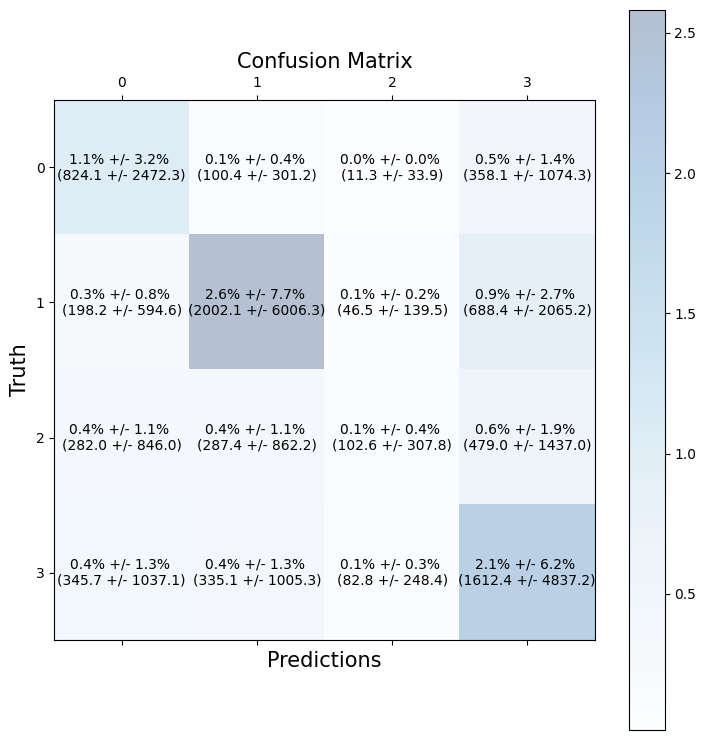

In [51]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(7.5, 7.5))
conf_matrix = np.mean(conf_mat,axis=0)
std_conf_matrix = np.std(conf_mat,axis=0)
non_norm_matrix = np.mean(non_norm_conf_mat,axis=0)
std_non_norm_matrix = np.std(non_norm_conf_mat,axis=0)

cmap = ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s="%1.1f%% +/- %1.1f%% \n(%1.1f +/- %1.1f)"%(conf_matrix[i, j],
                                                                      std_conf_matrix[i, j],
                                                                      non_norm_matrix[i, j],
                                                                      std_non_norm_matrix[i, j]
                                                                     ), 
                va='center', ha='center')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion Matrix', fontsize=15);
fig.colorbar(cmap);
plt.tight_layout()
plt.show()

In [52]:
conf_mat

array([[[10.62518534,  1.294465  ,  0.14569178,  4.61701113],
        [ 2.555408  , 25.81323088,  0.59952811,  8.87559469],
        [ 3.63584791,  3.70547053,  1.32282977,  6.17578422],
        [ 4.45713696,  4.32047034,  1.06754683, 20.78879849]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],



Repare que a eficiência da classe 3 está bastante degradada.

## Mostrar Lofar

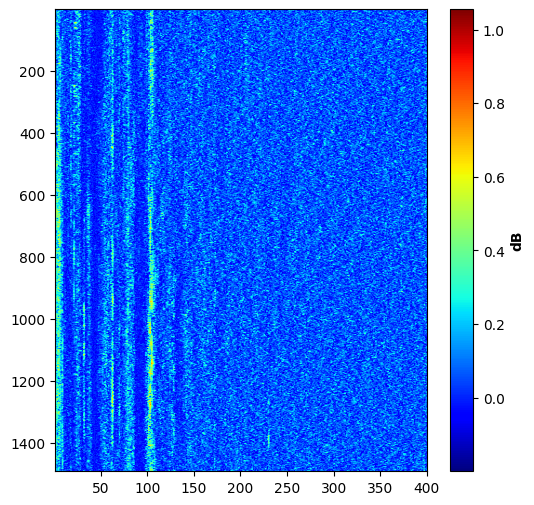

In [289]:
# Selecionando uma run
import matplotlib.pyplot as plt
selected_run = 'navio30'
fig, ax= plt.subplots(figsize=(6,6))
plot_data = df_all_data[df_all_data['run']==selected_run].filter(like='bin_').values
plt.imshow(plot_data,
           cmap="jet",extent=[1, 400, plot_data.shape[0],1],
           aspect="auto")
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB',fontweight='bold');